In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import gc
import sys
import time
import feather
import numpy as np
import pandas as pd
from contextlib import contextmanager
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import lightgbm as lgbm
import optuna

sys.path.append("/Users/ueda/Desktop/kaggle/mynavi/code/src/")
from logger import setup_logger, LOGGER
from trainer import train_lgbm
from util_tool import reduce_mem_usage

In [2]:
# ===============
# Constants
# ===============
DATA_DIR = "../input/"
TRAIN_PATH = os.path.join(DATA_DIR, "train.csv")
TEST_PATH = os.path.join(DATA_DIR, "test.csv")
#META_PATH = os.path.join(DATA_DIR, "meta.csv")
#META_PATH2 = os.path.join(DATA_DIR, "minincome_clean.csv")
SUB_PATH = os.path.join(DATA_DIR, "sample_submit.csv")
#FOLDS_PATH = "../input/mynavi_Stratifiedfold01.feather"  #folds気をつけて
#FOLDS_PATH = "../input/mynavi_Stratifiedfold_address.feather"
#FOLDS_PATH = "../input/mynavi_Stratifiedfold_rent.feather"
FOLDS_PATH = "../input/mynavi_Stratifiedfold_same_build.feather"
LOGGER_PATH = "log.txt"
ID_COLUMN = "id"


EXP_ID = "exp0_+address_poisson_outlin3class_TE_noWord_ekipeople+meta"

SAVE_PATH = f'../output/{EXP_ID}'
try:
    os.mkdir(SAVE_PATH)
except:
    print("Already directory created")

In [3]:
# ===============
# Settings
# ===============
pd.set_option('display.max_columns', 50)

SEED = 0
N_SPLITS = 5
LOG = False
LGBM_PARAMS = {
    'task': 'train',
    'boosting_type': 'gbdt',   #rf, gbdt
    'objective': 'poisson',    #regression, gamma, poisson gamma早すぎ
    'metric': "rmse",
    'learning_rate': 0.05,
    'max_depth': 8,             #9 244469711 > 8       3class(9:2220000) 
    'num_leaves': int(0.7*8**2),        #15 < int 
    'subsample': 0.9,
    'subsample_freq': 1,
    'colsample_bytree': 0.4, # 0.4, 0.7, 0.8　＜ 0.4最強
    'max_bin': 255,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,  #0.1
    'min_child_samples': 5,   #5と10使い分け
    'min_gain_to_split': 0.02,
    'min_data_in_bin': 3,
    'bin_construct_sample_cnt': 5000,
    'cat_l2': 5,     #5 > 10
    'verbose': -1,
    'nthread': -1,
    'seed': SEED,
}
LGBM_FIT_PARAMS = {
    'num_boost_round': 50000,
    'early_stopping_rounds': 100,
    'verbose_eval': 5000,
}

use_cols = []

drop_columns = ['fold_id', 'id', 'キッチン', 'バス・トイレ', '周辺環境',
                '室内設備', '所在階', '放送・通信', '間取り',
                '築年数', '賃料', '面積', '駐車場', "路線_0", "駅_0", "方角",
                 "路線_1", "駅_1", "路線_2", "駅_2", "契約期間", '建物構造', 'アクセス', "same_build"
]

categorical_features = ["catuse_駅_0", "catuse_路線_0", "所在地", "地域名", "地域_n丁目",
                        "cat_int間取り", "cat_building_height",'所在_区'
]


#TE_columns = ["所在_区", "cat_building_height", "cat_int間取り"
#]

TE_columns = ["所在_区", 'catuse_路線_0', 'catuse_駅_0', #"間取りtype", "cat_int間取り", "cat_building_height",
              "地域名", '地域_n丁目', "same_build"
] #244469711

#drop_columns = drop_columns + [col for col in categorical_features if col in TE_columns]
#categorical_features = [cat_col for cat_col in categorical_features if cat_col not in TE_columns]

FEATURES = [
    "../code/feature_csv/base_feature1.feather",
    "../code/feature_csv/nonleak_group_feature2.feather",
    #'../code/feature_csv/nonleak_nearStation_group_feature.feather',
    #'../code/feature_csv/near_access_feature.feather',
    "../code/feature_csv/word_contain_sparse_feature.feather",
    
    "../code/feature_csv/access_feature.feather",
    #"../code/feature_csv/access_feature+GMM.feather",
    
    "../code/feature_csv/address_latlng.feather",
    "../code/feature_csv/meta_features.feather",   #有
    "../code/feature_csv/out.feather",
    #"../code/feature_csv/tika_feature.feather"     
    #"../code/feature_csv/out_2.feather",
    "../code/feature_csv/eki_people.feather"
]


setup_logger(out_file=LOGGER_PATH)

2019-11-07 19:04:18,726 - INFO - logger set up


<RootLogger root (DEBUG)>

In [4]:
# TE_columns = ["所在_区", "cat_building_height", "cat_int間取り"] CV= 292975388

# TE_columns = ["所在_区", "間取りtype", 'catuse_路線_0', 'catuse_駅_0',
#           "cat_int間取り", "cat_building_height", "地域名", '地域_n丁目', "same_build"
#] CV = 

In [5]:
# ===============
# Functions
# ===============
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s')
    
def load_feature_feather(df, filename):
    feature = feather.read_dataframe(filename)
    df = pd.concat((df, feature), axis=1)
    del feature
    gc.collect()
    return df

def load_feature_csv(df, filename):
    feature = pd.csv(filename)
    df = pd.concat((df, feature), axis=1)
    del feature
    gc.collect()
    return df

def modify_rent(target, df_input):
    """ id == 5776 で賃料の0が一つ多い"""
    target = np.where(df_input["id"]==5776, 120350, target)
    
    return target


def TE_feature(df_main, df_add, TE_columns = TE_columns):
    df_out = pd.DataFrame()
    add_TE_cols = [f"TE_{col}_mul_面積" for col in TE_columns]
    tmp_cols = [f"TE_{col}" for col in TE_columns]
    TE_df = df_add[TE_columns]
    TE_df.columns = tmp_cols
    
    TE_mul_df = pd.DataFrame(TE_df[tmp_cols].values * df_main["float面積"].values.reshape(-1,1), columns=add_TE_cols)
    TE_mul_df.index = df_main.index
    TE_df.index = df_main.index
    
    TE_mul_df["std_TE賃料"] = TE_mul_df.std(axis=1)
    TE_mul_df["min_TE賃料"] = TE_mul_df.min(axis=1)
    TE_mul_df["max_TE賃料"] = TE_mul_df.max(axis=1)
    TE_mul_df["mean_TE賃料"] = TE_mul_df.mean(axis=1)
    
    df_out = pd.concat([TE_df, TE_mul_df], axis=1)
    
    return df_out

def calc_loss(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

## main

In [6]:
with timer("load data"):
    train = feather.read_dataframe(FOLDS_PATH)
    test = pd.read_csv(TEST_PATH)
    if LOG:
        y = np.log1p(train['賃料'].copy())
    else:
        y = train['賃料'].copy()
    folds = train[["fold_id"]].copy()
    n_train = len(train)
    train = train.append(test).reset_index(drop=True)
    del test
    gc.collect()

2019-11-07 19:04:19,445 - INFO - [load data] done in 1 s


In [7]:
with timer("load featuers"):
    for f in FEATURES:
        train = load_feature_feather(train, f)
        
    train["same_build"] = train["building_floor"].astype(str) + train["地域_n丁目"] + train["int築年"].astype(str)

2019-11-07 19:04:29,381 - INFO - [load featuers] done in 10 s


In [8]:
with timer("preprocessing"):
    for c in categorical_features:
        lbl = LabelEncoder()
        lbl.fit(list(train[c].astype("str").values))
        train[c] = lbl.transform(list(train[c].astype("str").values))

    
    """記入ミスの修正"""
    try:
        y = modify_rent(y, train[:n_train])
    except:
        pass
    
    try:
        train.drop(drop_columns, axis=1, inplace=True)
    except:
        pass
    
    
    """importtanceで区切るなら"""
    if len(use_cols)==0:
        test = train[n_train:]
        train = train[:n_train]
    
    elif len(use_cols)>0:
        test = test[use_cols]
        train = train[use_cols]
    
    
    """外れ値分類の特量追加"""
    #out = np.percentile(y, [85])
    #outlin =  np.where(y > out,1,0)
    #model = lgbm.LGBMClassifier().fit(train, outlin)
    #train["out"] = outlin
    #test["out"] = model.predict(test)
    
    #categorical_features = [cat_col for cat_col in categorical_features if cat_col not in TE_columns]
    
    train = reduce_mem_usage(train)
    train.to_feather(f"../features/{EXP_ID}_df.feather")
        
    #gc.collect()

    target_test = pd.read_csv(f'../code/feature_csv/target_encoding_test.csv')
    
    test = pd.concat([test, TE_feature(test, target_test)], axis=1)
    
    features = list(test.columns.values)

Memory usage of dataframe is 235.30 MB
column =  981
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
Memory usage after optimization is: 98.56 MB
Decreased by 58.1%


2019-11-07 19:05:24,193 - INFO - [preprocessing] done in 55 s


In [9]:
test.shape

(31262, 997)

In [10]:
with timer("train"):
    y_oof = np.empty(len(train), )
    y_test = []
    feature_importances = pd.DataFrame()

    for fold_id in range(N_SPLITS):
        with timer(f"fold {fold_id}"):
            x_train, y_train = train[folds.fold_id != fold_id], y[folds.fold_id != fold_id]
            x_val, y_val = train[folds.fold_id == fold_id], y[folds.fold_id == fold_id]
            
            TE_fold = pd.read_csv(f'../code/feature_csv/target_encoding_groupfold{fold_id}.csv')
            x_train = pd.concat([x_train, TE_feature(x_train, TE_fold[TE_fold["fold_id"]!=fold_id])], axis=1)
            x_val = pd.concat([x_val, TE_feature(x_val, TE_fold[TE_fold["fold_id"]==fold_id])], axis=1)
            
            y_pred_valid, y_pred_test, train_loss, valid_loss, importances, best_iter = train_lgbm(
                x_train, y_train, x_val, y_val, test,
                categorical_features=categorical_features,
                feature_name=features,
                fold_id=fold_id,
                lgb_params=LGBM_PARAMS,
                fit_params=LGBM_FIT_PARAMS,
                model_name=EXP_ID,
                loss_func=calc_loss,
                rank=False,
                calc_importances=True
            )
            y_oof[folds.fold_id == fold_id] = y_pred_valid
            y_test.append(y_pred_test)
            feature_importances = pd.concat([feature_importances, importances], axis=0, sort=False)

    feature_importances.to_csv(os.path.join(SAVE_PATH, "feature_importances.csv"), index=False)
    if LOG:
        y = np.expm1(y)
        y_oof = np.expm1(y_oof)
        y_test = np.expm1(y_test)
    score = calc_loss(y, y_oof)
    y_test = np.mean(y_test, axis=0)
    yoof_and_target = pd.DataFrame()
    yoof_and_target["賃料"] = y
    yoof_and_target[f'{EXP_ID}'] = y_oof
    yoof_and_target.to_csv(os.path.join(SAVE_PATH, "yoof_and_target.csv"), index=False)
    yoof_and_target.to_csv(f'../output/vs_trains/{EXP_ID}.csv', index=False)
    
    test_result = pd.DataFrame()
    test_result[f"{EXP_ID}"] = y_test
    test_result.to_csv(f'../output/test_results/{EXP_ID}.csv', index=False)
    
    LOGGER.info(f'CV={score}')

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1233]	valid's rmse: 15343.4


2019-11-07 19:06:42,903 - INFO - Best Iteration: 1233
2019-11-07 19:06:50,221 - INFO - [fold 0] done in 86 s


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1203]	valid's rmse: 17797.1


2019-11-07 19:08:07,782 - INFO - Best Iteration: 1203
2019-11-07 19:08:12,417 - INFO - [fold 1] done in 82 s


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[2247]	valid's rmse: 11504.4


2019-11-07 19:10:27,463 - INFO - Best Iteration: 2247
2019-11-07 19:10:34,976 - INFO - [fold 2] done in 143 s


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[2483]	valid's rmse: 14152.4


2019-11-07 19:13:05,732 - INFO - Best Iteration: 2483
2019-11-07 19:13:14,368 - INFO - [fold 3] done in 159 s


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1687]	valid's rmse: 14825.4


2019-11-07 19:14:40,259 - INFO - Best Iteration: 1687
2019-11-07 19:14:46,431 - INFO - [fold 4] done in 92 s
2019-11-07 19:14:46,836 - INFO - CV=221573275.20276815
2019-11-07 19:14:46,838 - INFO - [train] done in 563 s


In [11]:
"""if fold_id does not drop """
#(x_train[x_train["fold_id"]!=0]["fold_id"] == TE_feature[TE_feature["fold_id"]!=0]["fold_id"]).value_counts()

'if fold_id does not drop '

In [12]:
#TE_feature[TE_columns]["所在_区"].value_counts()

In [13]:
with timer("sub"):
    sub = pd.read_csv(SUB_PATH, header=None)
    sub[1] = y_test
    LOGGER.info(f'len sub={len(sub)}')
    sub.to_csv(os.path.join(SAVE_PATH,f'{EXP_ID}.csv'), index=False, header=None)

2019-11-07 19:14:46,865 - INFO - len sub=31262
2019-11-07 19:14:46,989 - INFO - [sub] done in 0 s


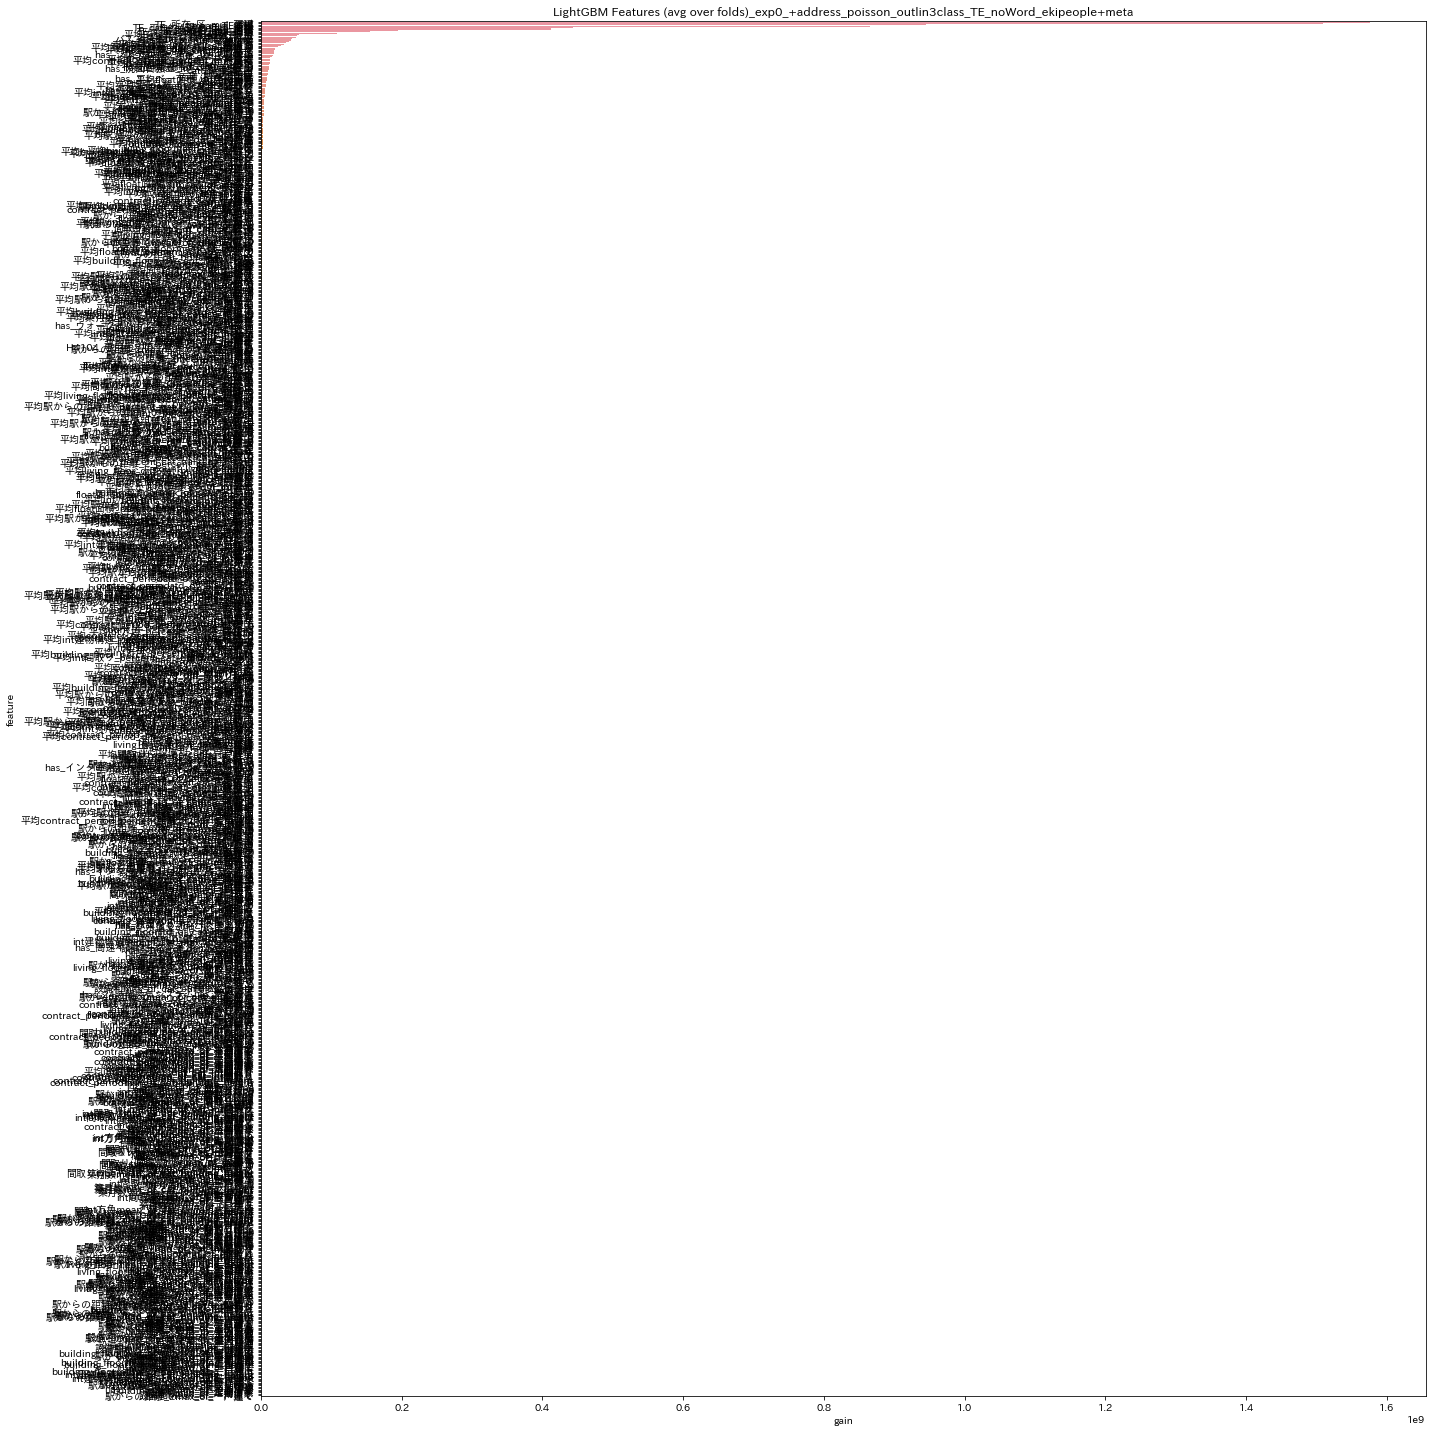

In [14]:
"""importtances visualization"""
cols = importances[["feature", "gain"]].groupby("feature").mean().sort_values(
    by="gain", ascending=False)[:1000].index

best_features = importances.loc[importances.feature.isin(cols)]
plt.figure(figsize=(20,20))
sns.barplot(x="gain", y="feature", data=best_features.sort_values(by="gain", ascending=False))
plt.title(f'LightGBM Features (avg over folds)_{EXP_ID}')
plt.tight_layout()
plt.savefig(os.path.join(SAVE_PATH,(f'lgbm_importances_{EXP_ID}.png')))

In [15]:
categorical_features
#TE_feature[TE_columns]

['catuse_駅_0',
 'catuse_路線_0',
 '所在地',
 '地域名',
 '地域_n丁目',
 'cat_int間取り',
 'cat_building_height',
 '所在_区']

In [16]:
pd.set_option('display.max_rows', 500)
importances.sort_values("gain", ascending=False)

,feature,gain,split,fold
966,out,1.576174e+09,176,4
987,TE_所在_区_mul_面積,1.508783e+09,439,4
996,mean_TE賃料,9.453943e+08,269,4
989,TE_catuse_駅_0_mul_面積,8.647624e+08,324,4
965,平均的な賃料相場_階数,4.428746e+08,438,4
990,TE_地域名_mul_面積,4.127202e+08,329,4
992,TE_same_build_mul_面積,1.941918e+08,927,4
961,平均的な賃料相場,1.555970e+08,234,4
964,平均的な賃料相場_階数_方角,1.073815e+08,272,4
949,catuse_駅_0,5.373483e+07,3006,4


In [17]:
use_cols = list(importances[importances["gain"]>100000]["feature"].values)
print(len(use_cols), len(train.columns))
use_cols = [col for col in use_cols if col in train.columns]
use_cols = use_cols + [col for col in categorical_features if col not in use_cols]

495 981


In [18]:
yoof_and_target[yoof_and_target["賃料"] == yoof_and_target["賃料"].max()]

,賃料,exp0_+address_poisson_outlin3class_TE_noWord_ekipeople+meta
5093,2500000,1.608073e+06


In [19]:
for i in TE_columns:
    print(importances[importances["feature"]==i])

   feature          gain  split  fold
24    所在_区  9.333882e+06    451     4
         feature          gain  split  fold
948  catuse_路線_0  1.116208e+07    932     4
        feature          gain  split  fold
949  catuse_駅_0  5.373483e+07   3006     4
   feature          gain  split  fold
26     地域名  4.003292e+07   3279     4
   feature          gain  split  fold
28  地域_n丁目  9.795874e+06   1998     4
Empty DataFrame
Columns: [feature, gain, split, fold]
Index: []


# ENSEMBLE

In [ ]:
x_train[x_train["max_TE賃料"]==x_train["max_TE賃料"].min()]

In [ ]:
test2 = test.reset_index()
[test2["out"]==1]

In [ ]:
sub

In [ ]:
up_model = pd.read_csv("../output/exp1_poisson_upper100000/exp1_poisson_upper100000_100000.csv", header=None)

In [ ]:
ens = sub[[0]]
ens["1"] = (np.where([test2["out"]==1], up_model[1], sub[1])).reshape(-1,1)

In [ ]:
ens.to_csv('ens.csv', index=False, header=None)